# Exploração - Wikipedia

In [1]:
from repository.mongo_utils import get_pages_content_collection
from repository.wikipedia import WikipediaRepo

wikipedia_repo = WikipediaRepo(collection=get_pages_content_collection())

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

### Obter todas as páginsa

In [3]:
pages = wikipedia_repo.find_all()

In [4]:
pages_df = pd.DataFrame(pages)
pages_df = pages_df.drop(['_id', 'ns', 'type', 'download', 'categories', 'wikitext'], axis='columns')
pages_df.head()

,pageid,title,country,text
0,22911,Geografia da Argentina,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
1,1996157,Banco Namuncurá,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
2,1393635,Campo de gelo do sul da Patagónia,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
3,3425259,Cerro de la Gloria,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
4,1753443,Chaco Austral,Argentina,"<div class=""mw-parser-output""><div style=""righ..."


### Contagem de posts

In [ ]:
print(f'Foram encontradas {len(pages_df)} páginas com contéudo')

## Exploração antes da limpeza

### Tamanho médio dos documentos

In [ ]:
def describe_lengths(lenghts):
    print("Measures of Central Tendency")
    print("Mean =", np.mean(lenghts))
    print("Median =", np.median(lenghts))
    print("Measures of Dispersion")
    print("Minimum =", np.amin(lenghts))
    print("Maximum =", np.amax(lenghts))
    print("Range =", np.ptp(lenghts))
    print("Varience =", np.var(lenghts))
    print("Standard Deviation =", np.std(lenghts))

In [ ]:
text_lengths = pages_df['text'].apply(len)
pages_df['raw_length'] = text_lengths

Algumas considerações

- Tamanho mínimo de 799 incluindo tags html indica que pode haver documentos muito pequenos
- Desvio padrão maior que a média indica que pode haver uma variação muito grande nos tamanhos dos documentos
    * Verificar quantiles para ver a variação por quartis

In [ ]:
describe_lengths(text_lengths)

In [ ]:
np.quantile(text_lengths, [0, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

#### Verificar distribuição de tamanhos de documentos

In [ ]:
sns.displot(pages_df, x='raw_length')

In [ ]:
# Analisar documentos acima de 100000 caracteres
pages_df_acima_100k = pages_df[pages_df['raw_length'] >= 100000]
pages_df_acima_100k.shape

## Limpeza de dados

In [ ]:
from limpeza.limpeza_texto import remover_html_tags

import re

In [5]:
texts = pages_df['text'].values
texto = texts[0] 


### Primeira  tentativa - removendo elementos individualmente

In [ ]:
t = remover_html_tags(texto)
t = re.sub('body\.skin\-[a-z]+ ', '', t)
t = re.sub('.mw\-parser-[a-z]+ ', '', t)
t = re.sub('t[hd]\.mbox\-[a-z]+[ ,]', '', t)
t = re.sub('table\.[acfiot]mbox,', '', t)
t = re.sub('table\.[acfiot]mbox\-[a-z]+,', '', t)
t = re.sub('\.[ait]mbox[ ,]', '', t)
t = re.sub('\.mbox\-[a-z]+[ ,]', '', t)
t = re.sub('\.tmbox\.mbox\-[a-z]+[ ,]', '', t)
t = re.sub('\.mediawiki ', '', t)
t = re.sub('\.compact-ambox[ ,]', '', t)

print(f'Tamanho do texto : {len(t)}/{len(texto)}')


### Segunda tentativa

- Peguei o conteúdo html, colei em um formatador externo e decidi tomar as seguintes ações
    * Remover tag ```<scripts>``` e todo seu conteúdo interno

In [ ]:
re

In [ ]:
# Pegando segundo texto, que tem tamanho 33027, mais perto da media
# [len(t) for t in texts[:20]]

texto = texts[3]

In [ ]:
t = re.sub('<style .*?style>', '', texto) # Removendo tag de estilos
print(f'Tamanho do texto apos remocao de estilos: {len(t)}/{len(texto)}. Aproximadamente {(len(t)/len(texto)) * 100:.2f}% mantido')

t = re.sub('\n', '', t)
t = re.sub('<table class="box-Sem_fontes.*?/table>', '', t)
t = re.sub('<!--.*?-->', '', t) # Remover comentarios
print(f'Tamanho do texto apos remocao conteudo: {len(t)}/{len(texto)}. Aproximadamente {(len(t)/len(texto)) * 100:.2f}% mantido')


## Extração de parágrafos

Após conseguir remover um pouco de texto na tentativa 2 anterior vamos extrair apenas textos de parágrafos e ver como fica o resultado. Um risco nesta abordagem é tirar conteúdos interessantes de tabelas ou listas mas deixar este problema de lado por enquanto.

- **Vou ignorar inclusive a limpeza de texto feito previamente e ir direto aos parágrafos.**
- **Avaliar possibilidade de pegar conteúdo <pre></pre>.**

- Uma análise posterior de tamanho dos documentos deve ser feita
- Deve-se remover tags html de dentro dos parágrafos pois estes podem conter elementos como links ou spans
    * **Isto é bem resolvido pelo método getText() do BeautifulSoup quando aplicado ao elemento p**

In [10]:
from bs4 import BeautifulSoup

In [ ]:
soup = BeautifulSoup(texto, 'html.parser')

In [ ]:
ps = soup.find_all('p')
pres = soup.find_all('pre')

In [ ]:
[p.getText() for p in ps]

In [ ]:
[pre.getText() for pre in pres]

In [8]:
def extract_texta(raw_text):
    soup = BeautifulSoup(raw_text, 'html.parser')
    ps = soup.find_all('p')
    pres = soup.find_all('pre')

    ps_text = ' '.join([p.getText() for p in ps])
    pres_text = ' '.join([pre.getText() for pre in pres])

    return (ps_text, pres_text)

Da primeira vez que executei o extrator de textos das páginas html ele demorou 38.5 segundos para extrair o conteudo de todas as páginas. Considerar se não vale a pena extrair e guardar este conteúdo MongoDB a partir do momento em que a extração já estiver definida.

In [11]:
extracted = [extract_texta(t) for t in texts]


In [12]:
tamanhos_pres = [len(ex[1]) for ex in extracted]
tamanho_df = pd.DataFrame(tamanhos_pres, columns=['tamanhopre'])

<AxesSubplot:xlabel='tamanhopre', ylabel='Count'>

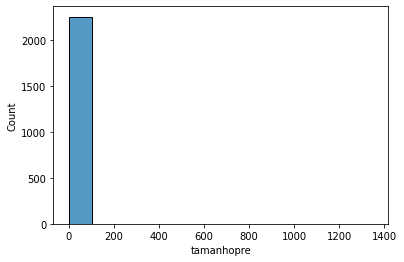

In [16]:
sns.histplot(tamanho_df, x='tamanhopre')

In [17]:
tamanho_df['tamanhopre'].describe()

count    2252.000000
mean        0.644316
std        28.508598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1350.000000
Name: tamanhopre, dtype: float64

In [19]:
# Apenas 3 páginas contém texto pre
existe_pre = [ex[1] for ex in extracted if len(ex[1]) > 0]
len(existe_pre)

3

In [21]:
textos_completos = [ex[0] + ' ' + ex[1] if len(ex[1]) > 0 else ex[0] for ex in extracted]

In [22]:
tamanhos_textos_completos = [len(t) for t in textos_completos]
np.quantile(tamanhos_textos_completos, q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

array([     0.  ,    128.2 ,    261.  ,    480.  ,   1015.25,   2347.7 ,
         4101.8 , 106406.  ])

In [24]:
# Breaks texts in words to count words
texts_words = [t.split(' ') for t in textos_completos]

In [25]:
tamanhos_em_palavras = [len(tw) for tw in texts_words]

In [27]:
# The first command is to suppress the scientific notation
np.set_printoptions(suppress=True)
np.quantile(tamanhos_em_palavras, q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

array([    1.  ,    21.  ,    40.75,    79.  ,   160.  ,   349.7 ,
         649.45, 16745.  ])

### Análise do tamanho de palavras

- [https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883](https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883)
- [https://www.researchgate.net/post/What-would-be-considered-the-least-number-of-documents-for-training-an-LDA-SLDA-topic-model-Is-a-corpus-of-200-documents-large-enough](https://www.researchgate.net/post/What-would-be-considered-the-least-number-of-documents-for-training-an-LDA-SLDA-topic-model-Is-a-corpus-of-200-documents-large-enough)
- [https://stackoverflow.com/questions/36673316/latent-dirichlet-allocationlda-performance-by-limiting-word-size-for-corpus-do](https://stackoverflow.com/questions/36673316/latent-dirichlet-allocationlda-performance-by-limiting-word-size-for-corpus-do)
- [https://www.machinelearningplus.com/topic-modeling-visualization-how-to-present-results-lda-models/](https://www.machinelearningplus.com/topic-modeling-visualization-how-to-present-results-lda-models/)
- [https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full](https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full)
- [https://arxiv.org/pdf/1904.07695.pdf](https://arxiv.org/pdf/1904.07695.pdf)